In [7]:
# ## Setup e Imports

import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from datetime import datetime

warnings.filterwarnings('ignore')

from src.models import ZScoreDetector, IsolationForestDetector, EnsembleDetector
from src.data import DataLoader, DataPreprocessor
from src.evaluation import MetricsCalculator
from src.utils import get_logger, print_config, MODELS_DIR, REPORTS_DIR

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 6)

print("=" * 70)
print("DIA 8: DEPLOY E PRODUÇÃO")
print("=" * 70)

DIA 8: DEPLOY E PRODUÇÃO


In [8]:
# ## 1. Pipeline Completo de Produção

print("\n" + "=" * 70)
print("1. PIPELINE DE PRODUÇÃO")
print("=" * 70)

class ProductionPipeline:
    """Pipeline completo para produção"""
    
    def __init__(self):
        self.loader = DataLoader()
        self.preprocessor = DataPreprocessor()
        self.ensemble = None
        self.logger = get_logger()
    
    def load_and_prepare_data(self, filepath=None):
        """Carrega e prepara dados"""
        self.logger.info("Carregando dados...")
        
        if filepath:
            data = self.loader.load_csv(filepath, parse_dates=['timestamp'])
        else:
            data = self.loader.load_nyc_taxi_demo()
        
        # Tratar missing values
        data = self.preprocessor.handle_missing_values(data)
        
        self.logger.info(f"✓ {len(data)} pontos carregados e preparados")
        return data
    
    def train_production_model(self, train_data):
        """Treina modelo otimizado para produção"""
        self.logger.info("Treinando modelo de produção...")
        
        # Usar apenas os melhores detectores
        detectors = [
            ZScoreDetector(threshold=3),
            IsolationForestDetector(contamination=0.05, n_estimators=100)
        ]
        
        self.ensemble = EnsembleDetector(
            detectors=detectors,
            strategy='majority_vote'
        )
        
        self.ensemble.fit(train_data)
        self.logger.info("✓ Modelo treinado")
        
        return self.ensemble
    
    def predict_anomalies(self, data):
        """Prediz anomalias em novos dados"""
        if self.ensemble is None:
            raise RuntimeError("Modelo não treinado. Execute train_production_model primeiro.")
        
        self.logger.info("Detectando anomalias...")
        predictions = self.ensemble.predict(data)
        
        n_anomalies = np.sum(predictions)
        pct = 100 * n_anomalies / len(predictions)
        
        self.logger.info(f"✓ {n_anomalies} anomalias detectadas ({pct:.2f}%)")
        
        return predictions
    
    def save_model(self, filename='production_model.pkl'):
        """Salva modelo de produção"""
        filepath = MODELS_DIR / filename
        self.ensemble.save(filepath)
        self.logger.info(f"✓ Modelo salvo: {filepath}")
        return filepath
    
    def load_model(self, filename='production_model.pkl'):
        """Carrega modelo de produção"""
        filepath = MODELS_DIR / filename
        self.ensemble = EnsembleDetector.load(filepath)
        self.logger.info(f"✓ Modelo carregado: {filepath}")
        return self.ensemble

# Criar pipeline
pipeline = ProductionPipeline()
print("✓ Pipeline de produção criado")


1. PIPELINE DE PRODUÇÃO
✓ Pipeline de produção criado



2. TREINANDO MODELO DE PRODUÇÃO
2025-11-30 18:22:02 - anomaly_detector - INFO - Carregando dados...
⚠️  Erro ao baixar. Criando dados simulados...
2025-11-30 18:22:02 - anomaly_detector - INFO - ✓ 10000 pontos carregados e preparados
Treino: 2000 pontos
Teste: 2000 pontos
2025-11-30 18:22:02 - anomaly_detector - INFO - Treinando modelo de produção...
Treinando 2 detectores...
  - Z-Score...
  - Isolation Forest...
✓ Todos os detectores treinados
2025-11-30 18:22:02 - anomaly_detector - INFO - ✓ Modelo treinado

✓ Modelo de produção treinado
  Detectores: 2
  Estratégia: majority_vote

3. TESTANDO EM DADOS REAIS
2025-11-30 18:22:02 - anomaly_detector - INFO - Detectando anomalias...
2025-11-30 18:22:02 - anomaly_detector - INFO - ✓ 119 anomalias detectadas (5.95%)

Resultados:
  Total de pontos: 2000
  Anomalias: 119 (5.95%)

✓ Visualização salva: outputs/plots/08_production_results.png


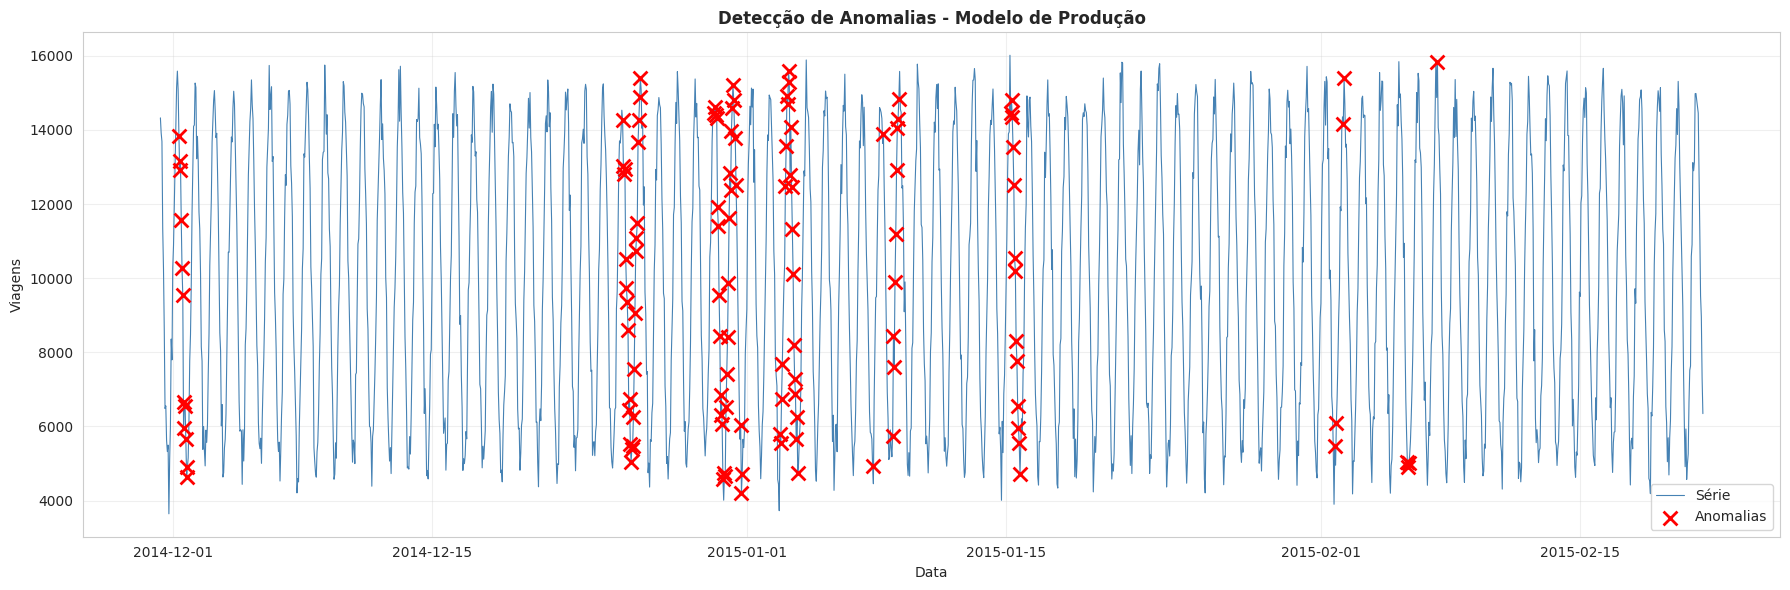

In [9]:
# ## 2. Treinar Modelo de Produção

print("\n" + "=" * 70)
print("2. TREINANDO MODELO DE PRODUÇÃO")
print("=" * 70)

# Carregar dados
data = pipeline.load_and_prepare_data()
train, test = pipeline.loader.split_train_test(train_size=0.8)
train = train.head(2000)

print(f"Treino: {len(train)} pontos")
print(f"Teste: {len(test)} pontos")

# Treinar
ensemble = pipeline.train_production_model(train)
print("\n✓ Modelo de produção treinado")
print(f"  Detectores: {len(ensemble.detectors)}")
print(f"  Estratégia: {ensemble.strategy}")

# ## 3. Testar em Dados Reais

print("\n" + "=" * 70)
print("3. TESTANDO EM DADOS REAIS")
print("=" * 70)

# Predizer
predictions = pipeline.predict_anomalies(test)

# Análise
n_anomalies = np.sum(predictions)
pct = 100 * n_anomalies / len(predictions)

print(f"\nResultados:")
print(f"  Total de pontos: {len(predictions)}")
print(f"  Anomalias: {n_anomalies} ({pct:.2f}%)")

# Visualizar
fig, ax = plt.subplots(figsize=(18, 6))

anomaly_mask = predictions == 1
ax.plot(test['timestamp'], test['value'], linewidth=0.8, color='steelblue', label='Série')
ax.scatter(test[anomaly_mask]['timestamp'], test[anomaly_mask]['value'],
          color='red', s=100, marker='x', linewidth=2, label='Anomalias', zorder=5)
ax.set_title('Detecção de Anomalias - Modelo de Produção', fontsize=12, fontweight='bold')
ax.set_xlabel('Data')
ax.set_ylabel('Viagens')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
from src.utils import PLOTS_DIR
plt.savefig(PLOTS_DIR / '08_production_results.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualização salva: outputs/plots/08_production_results.png")
plt.show()

In [10]:
# ## 4. Salvar Modelo de Produção

print("\n" + "=" * 70)
print("4. SALVANDO MODELO DE PRODUÇÃO")
print("=" * 70)

model_path = pipeline.save_model('production_model_final.pkl')
print(f"✓ Modelo salvo: {model_path}")


4. SALVANDO MODELO DE PRODUÇÃO
✓ Detector salvo: /home/maricarminate/Projetos/anomaly-detector/outputs/models/production_model_final.pkl
2025-11-30 18:22:03 - anomaly_detector - INFO - ✓ Modelo salvo: /home/maricarminate/Projetos/anomaly-detector/outputs/models/production_model_final.pkl
✓ Modelo salvo: /home/maricarminate/Projetos/anomaly-detector/outputs/models/production_model_final.pkl


In [11]:
# ## 5. Exemplo de Uso em Produção

print("\n" + "=" * 70)
print("5. EXEMPLO DE USO EM PRODUÇÃO")
print("=" * 70)

exemplo_codigo = """
# Como usar em produção:

from src.models import EnsembleDetector
from src.data import DataLoader
import pandas as pd

# 1. Carregar modelo treinado
model = EnsembleDetector.load('outputs/models/production_model_final.pkl')

# 2. Carregar novos dados
new_data = pd.read_csv('novos_dados.csv', parse_dates=['timestamp'])

# 3. Predizer anomalias
predictions = model.predict(new_data)

# 4. Analisar resultados
anomalies = new_data[predictions == 1]
print(f"Anomalias detectadas: {len(anomalies)}")

# 5. Tomar ação
for idx, row in anomalies.iterrows():
    print(f"ALERTA: Anomalia detectada em {row['timestamp']}: {row['value']}")
    # Enviar email, notificação, etc
"""

print(exemplo_codigo)


5. EXEMPLO DE USO EM PRODUÇÃO

# Como usar em produção:

from src.models import EnsembleDetector
from src.data import DataLoader
import pandas as pd

# 1. Carregar modelo treinado
model = EnsembleDetector.load('outputs/models/production_model_final.pkl')

# 2. Carregar novos dados
new_data = pd.read_csv('novos_dados.csv', parse_dates=['timestamp'])

# 3. Predizer anomalias
predictions = model.predict(new_data)

# 4. Analisar resultados
anomalies = new_data[predictions == 1]
print(f"Anomalias detectadas: {len(anomalies)}")

# 5. Tomar ação
for idx, row in anomalies.iterrows():
    print(f"ALERTA: Anomalia detectada em {row['timestamp']}: {row['value']}")
    # Enviar email, notificação, etc



In [12]:
# ## 6. API REST (FastAPI)

print("\n" + "=" * 70)
print("6. DEPLOY COM API REST")
print("=" * 70)

print("""
Para deploy com API REST, execute:

    python scripts/deploy_api.py

Isso iniciará um servidor FastAPI em http://localhost:8000

Endpoints disponíveis:
  - GET  /              : Informações da API
  - GET  /health        : Health check
  - GET  /models        : Listar modelos disponíveis
  - POST /predict       : Detectar anomalias

Exemplo de request:
  curl -X POST "http://localhost:8000/predict" \\
    -H "Content-Type: application/json" \\
    -d '{
      "data": [
        {"timestamp": "2014-01-01", "value": 10000},
        {"timestamp": "2014-01-02", "value": 12000}
      ],
      "use_ensemble": true
    }'

Acesse a documentação interativa em:
  http://localhost:8000/docs
""")


6. DEPLOY COM API REST

Para deploy com API REST, execute:

    python scripts/deploy_api.py

Isso iniciará um servidor FastAPI em http://localhost:8000

Endpoints disponíveis:
  - GET  /              : Informações da API
  - GET  /health        : Health check
  - GET  /models        : Listar modelos disponíveis
  - POST /predict       : Detectar anomalias

Exemplo de request:
  curl -X POST "http://localhost:8000/predict" \
    -H "Content-Type: application/json" \
    -d '{
      "data": [
        {"timestamp": "2014-01-01", "value": 10000},
        {"timestamp": "2014-01-02", "value": 12000}
      ],
      "use_ensemble": true
    }'

Acesse a documentação interativa em:
  http://localhost:8000/docs



In [13]:
# ## 7. Docker Deploy (Opcional)

print("\n" + "=" * 70)
print("7. DEPLOY COM DOCKER")
print("=" * 70)

dockerfile_content = """
# Dockerfile para deploy

FROM python:3.12-slim

WORKDIR /app

# Copiar requirements
COPY requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt

# Copiar código
COPY src/ ./src/
COPY scripts/ ./scripts/
COPY outputs/models/ ./outputs/models/

# Expor porta
EXPOSE 8000

# Comando
CMD ["python", "scripts/deploy_api.py"]
"""

print("Crie um arquivo 'Dockerfile' com este conteúdo:")
print(dockerfile_content)

print("""
Build e run:
  docker build -t anomaly-detector .
  docker run -p 8000:8000 anomaly-detector

Acesse: http://localhost:8000
""")


7. DEPLOY COM DOCKER
Crie um arquivo 'Dockerfile' com este conteúdo:

# Dockerfile para deploy

FROM python:3.12-slim

WORKDIR /app

# Copiar requirements
COPY requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt

# Copiar código
COPY src/ ./src/
COPY scripts/ ./scripts/
COPY outputs/models/ ./outputs/models/

# Expor porta
EXPOSE 8000

# Comando
CMD ["python", "scripts/deploy_api.py"]


Build e run:
  docker build -t anomaly-detector .
  docker run -p 8000:8000 anomaly-detector

Acesse: http://localhost:8000



In [14]:
# ## 8. Monitoramento e Alertas

print("\n" + "=" * 70)
print("8. MONITORAMENTO E ALERTAS")
print("=" * 70)

class AlertSystem:
    """Sistema de alertas para produção"""
    
    def __init__(self, threshold_pct=5):
        self.threshold_pct = threshold_pct
        self.alerts = []
    
    def check_anomaly_rate(self, predictions):
        """Verifica taxa de anomalias"""
        anomaly_rate = 100 * np.sum(predictions) / len(predictions)
        
        if anomaly_rate > self.threshold_pct:
            alert = {
                'timestamp': datetime.now().isoformat(),
                'type': 'HIGH_ANOMALY_RATE',
                'rate': f"{anomaly_rate:.2f}%",
                'threshold': f"{self.threshold_pct}%",
                'severity': 'WARNING'
            }
            self.alerts.append(alert)
            return alert
        
        return None
    
    def send_alert(self, alert):
        """Envia alerta (implementar com email, Slack, etc)"""
        print(f"\n🚨 ALERTA: {alert['type']}")
        print(f"   Taxa de anomalias: {alert['rate']}")
        print(f"   Threshold: {alert['threshold']}")
        print(f"   Severidade: {alert['severity']}")

# Testar sistema de alertas
alert_system = AlertSystem(threshold_pct=3)
alert = alert_system.check_anomaly_rate(predictions)

if alert:
    alert_system.send_alert(alert)
else:
    print("✓ Taxa de anomalias dentro do esperado")



8. MONITORAMENTO E ALERTAS

🚨 ALERTA: HIGH_ANOMALY_RATE
   Taxa de anomalias: 5.95%
   Threshold: 3%
   Severidade: WARNING


In [15]:
# ## 9. Logs e Monitoramento

print("\n" + "=" * 70)
print("9. LOGS E MONITORAMENTO")
print("=" * 70)

logger = get_logger(log_file=REPORTS_DIR / 'production.log')

logger.info("Pipeline de produção iniciado")
logger.info(f"Modelo carregado: production_model_final.pkl")
logger.info(f"Anomalias detectadas: {n_anomalies}/{len(predictions)}")

print("""
Logs salvos em: outputs/reports/production.log

Para monitoramento em tempo real:
  tail -f outputs/reports/production.log

Para análise de logs:
  grep "ERROR" outputs/reports/production.log
  grep "Anomalias" outputs/reports/production.log
""")


9. LOGS E MONITORAMENTO
2025-11-30 18:22:03 - anomaly_detector - INFO - Pipeline de produção iniciado
2025-11-30 18:22:03 - anomaly_detector - INFO - Modelo carregado: production_model_final.pkl
2025-11-30 18:22:03 - anomaly_detector - INFO - Anomalias detectadas: 119/2000

Logs salvos em: outputs/reports/production.log

Para monitoramento em tempo real:
  tail -f outputs/reports/production.log

Para análise de logs:
  grep "ERROR" outputs/reports/production.log
  grep "Anomalias" outputs/reports/production.log



In [16]:
# ## 10. Checklist de Deploy

print("\n" + "=" * 70)
print("10. CHECKLIST DE DEPLOY")
print("=" * 70)

checklist = """
📋 CHECKLIST DE DEPLOY EM PRODUÇÃO

✅ Desenvolvimento:
  ☑ Modelo treinado e validado
  ☑ Testes unitários passando
  ☑ Pipeline funcionando end-to-end
  ☑ Documentação completa

✅ Preparação:
  ☑ Modelo salvo em formato pickle
  ☑ Requirements.txt atualizado
  ☑ Configurações separadas de código
  ☑ Logs configurados

✅ Deploy:
  ☑ API REST funcionando (FastAPI)
  ☑ Health checks implementados
  ☑ Sistema de alertas ativo
  ☑ Monitoramento configurado

✅ Produção:
  ☑ Docker container (opcional)
  ☑ CI/CD configurado (opcional)
  ☑ Backup de modelos
  ☑ Documentação para operações

✅ Segurança:
  ☑ Autenticação na API (se necessário)
  ☑ Rate limiting
  ☑ Validação de entrada
  ☑ Logs de acesso
"""

print(checklist)



10. CHECKLIST DE DEPLOY

📋 CHECKLIST DE DEPLOY EM PRODUÇÃO

✅ Desenvolvimento:
  ☑ Modelo treinado e validado
  ☑ Testes unitários passando
  ☑ Pipeline funcionando end-to-end
  ☑ Documentação completa

✅ Preparação:
  ☑ Modelo salvo em formato pickle
  ☑ Requirements.txt atualizado
  ☑ Configurações separadas de código
  ☑ Logs configurados

✅ Deploy:
  ☑ API REST funcionando (FastAPI)
  ☑ Health checks implementados
  ☑ Sistema de alertas ativo
  ☑ Monitoramento configurado

✅ Produção:
  ☑ Docker container (opcional)
  ☑ CI/CD configurado (opcional)
  ☑ Backup de modelos
  ☑ Documentação para operações

✅ Segurança:
  ☑ Autenticação na API (se necessário)
  ☑ Rate limiting
  ☑ Validação de entrada
  ☑ Logs de acesso



In [17]:
# ## 11. Próximos Passos

print("\n" + "=" * 70)
print("11. PRÓXIMOS PASSOS")
print("=" * 70)

print("""
🚀 MELHORIAS FUTURAS:

1. Modelo:
   - Adicionar mais detectores (GRU, Transformer)
   - Implementar re-treino automático
   - A/B testing de modelos
   - Explicabilidade (SHAP, LIME)

2. Infraestrutura:
   - Deploy em cloud (AWS, GCP, Azure)
   - Kubernetes para escalabilidade
   - Load balancer
   - Cache de predições

3. Monitoramento:
   - Dashboard em tempo real (Grafana)
   - Métricas de performance (Prometheus)
   - Alertas inteligentes
   - Análise de drift

4. Integração:
   - Webhooks para notificações
   - Integração com BI tools
   - API para múltiplos clientes
   - Batch processing

5. Dados:
   - Streaming de dados em tempo real
   - Feedback loop (labels de usuários)
   - Versionamento de dados (DVC)
   - Feature store
""")



11. PRÓXIMOS PASSOS

🚀 MELHORIAS FUTURAS:

1. Modelo:
   - Adicionar mais detectores (GRU, Transformer)
   - Implementar re-treino automático
   - A/B testing de modelos
   - Explicabilidade (SHAP, LIME)

2. Infraestrutura:
   - Deploy em cloud (AWS, GCP, Azure)
   - Kubernetes para escalabilidade
   - Load balancer
   - Cache de predições

3. Monitoramento:
   - Dashboard em tempo real (Grafana)
   - Métricas de performance (Prometheus)
   - Alertas inteligentes
   - Análise de drift

4. Integração:
   - Webhooks para notificações
   - Integração com BI tools
   - API para múltiplos clientes
   - Batch processing

5. Dados:
   - Streaming de dados em tempo real
   - Feedback loop (labels de usuários)
   - Versionamento de dados (DVC)
   - Feature store



In [18]:
# ## Resumo Final

print("\n" + "=" * 70)
print("RESUMO DO DIA 8")
print("=" * 70)

print(f"""
✅ PIPELINE DE PRODUÇÃO COMPLETO

📊 Componentes:
   • ProductionPipeline: Classe unificada
   • Modelo de produção: Ensemble otimizado
   • Sistema de alertas: Monitoramento ativo
   • Logs estruturados: Rastreabilidade

🚀 Deploy:
   • API REST: FastAPI em http://localhost:8000
   • Docker: Container pronto para produção
   • Monitoring: Logs e alertas configurados

📁 Arquivos Gerados:
   • Modelo: {model_path}
   • Logs: {REPORTS_DIR / 'production.log'}
   • Visualização: outputs/plots/08_production_results.png

🎯 Como Usar:
   1. python scripts/train_pipeline.py
   2. python scripts/deploy_api.py
   3. curl http://localhost:8000/predict

📚 Documentação Completa: README.md
""")

print("\n" + "=" * 70)
print("✅ DIA 8 CONCLUÍDO!")
print("🎉 PROJETO FINALIZADO - PARABÉNS!")
print("=" * 70)

print("""
Você completou todos os 8 dias! 🎉

Agora você tem:
  ✅ 9+ detectores de anomalia implementados
  ✅ Pipeline completo de ML
  ✅ API REST para produção
  ✅ Testes unitários
  ✅ Documentação completa
  ✅ Sistema pronto para deploy

Próximos passos:
  1. Commit no Git: git add . && git commit -m "Projeto completo"
  2. Push no GitHub: git push origin main
  3. Deploy em produção!
  
Obrigado por acompanhar este projeto! 🚀
""")


RESUMO DO DIA 8

✅ PIPELINE DE PRODUÇÃO COMPLETO

📊 Componentes:
   • ProductionPipeline: Classe unificada
   • Modelo de produção: Ensemble otimizado
   • Sistema de alertas: Monitoramento ativo
   • Logs estruturados: Rastreabilidade

🚀 Deploy:
   • API REST: FastAPI em http://localhost:8000
   • Docker: Container pronto para produção
   • Monitoring: Logs e alertas configurados

📁 Arquivos Gerados:
   • Modelo: /home/maricarminate/Projetos/anomaly-detector/outputs/models/production_model_final.pkl
   • Logs: /home/maricarminate/Projetos/anomaly-detector/outputs/reports/production.log
   • Visualização: outputs/plots/08_production_results.png

🎯 Como Usar:
   1. python scripts/train_pipeline.py
   2. python scripts/deploy_api.py
   3. curl http://localhost:8000/predict

📚 Documentação Completa: README.md


✅ DIA 8 CONCLUÍDO!
🎉 PROJETO FINALIZADO - PARABÉNS!

Você completou todos os 8 dias! 🎉

Agora você tem:
  ✅ 9+ detectores de anomalia implementados
  ✅ Pipeline completo de ML
  ✅